# Breast cancer data analysis

In [ ]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

In [3]:
df = pd.read_csv("/Users/ramonsotogarcia/Desktop/Data/Breast cancer/Breast_cancer_data.csv", header = 0)

df.head(5)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [4]:
df.dtypes

mean_radius        float64
mean_texture       float64
mean_perimeter     float64
mean_area          float64
mean_smoothness    float64
diagnosis            int64
dtype: object

In [5]:
df.isna().sum(axis = 0) / df.shape[0]

mean_radius        0.0
mean_texture       0.0
mean_perimeter     0.0
mean_area          0.0
mean_smoothness    0.0
diagnosis          0.0
dtype: float64

### Scaling

In [6]:
from sklearn.preprocessing import StandardScaler


#split data into predictors and response variable

y = df["diagnosis"]

x = df.drop(columns = ["diagnosis"])


#standard scaling of the features

x_scaled = StandardScaler().fit_transform(x)
x_scaled = pd.DataFrame(data = x_scaled, columns = x.columns)
x_scaled["diagnosis"] = y



## Data visualisation

### Boxplots

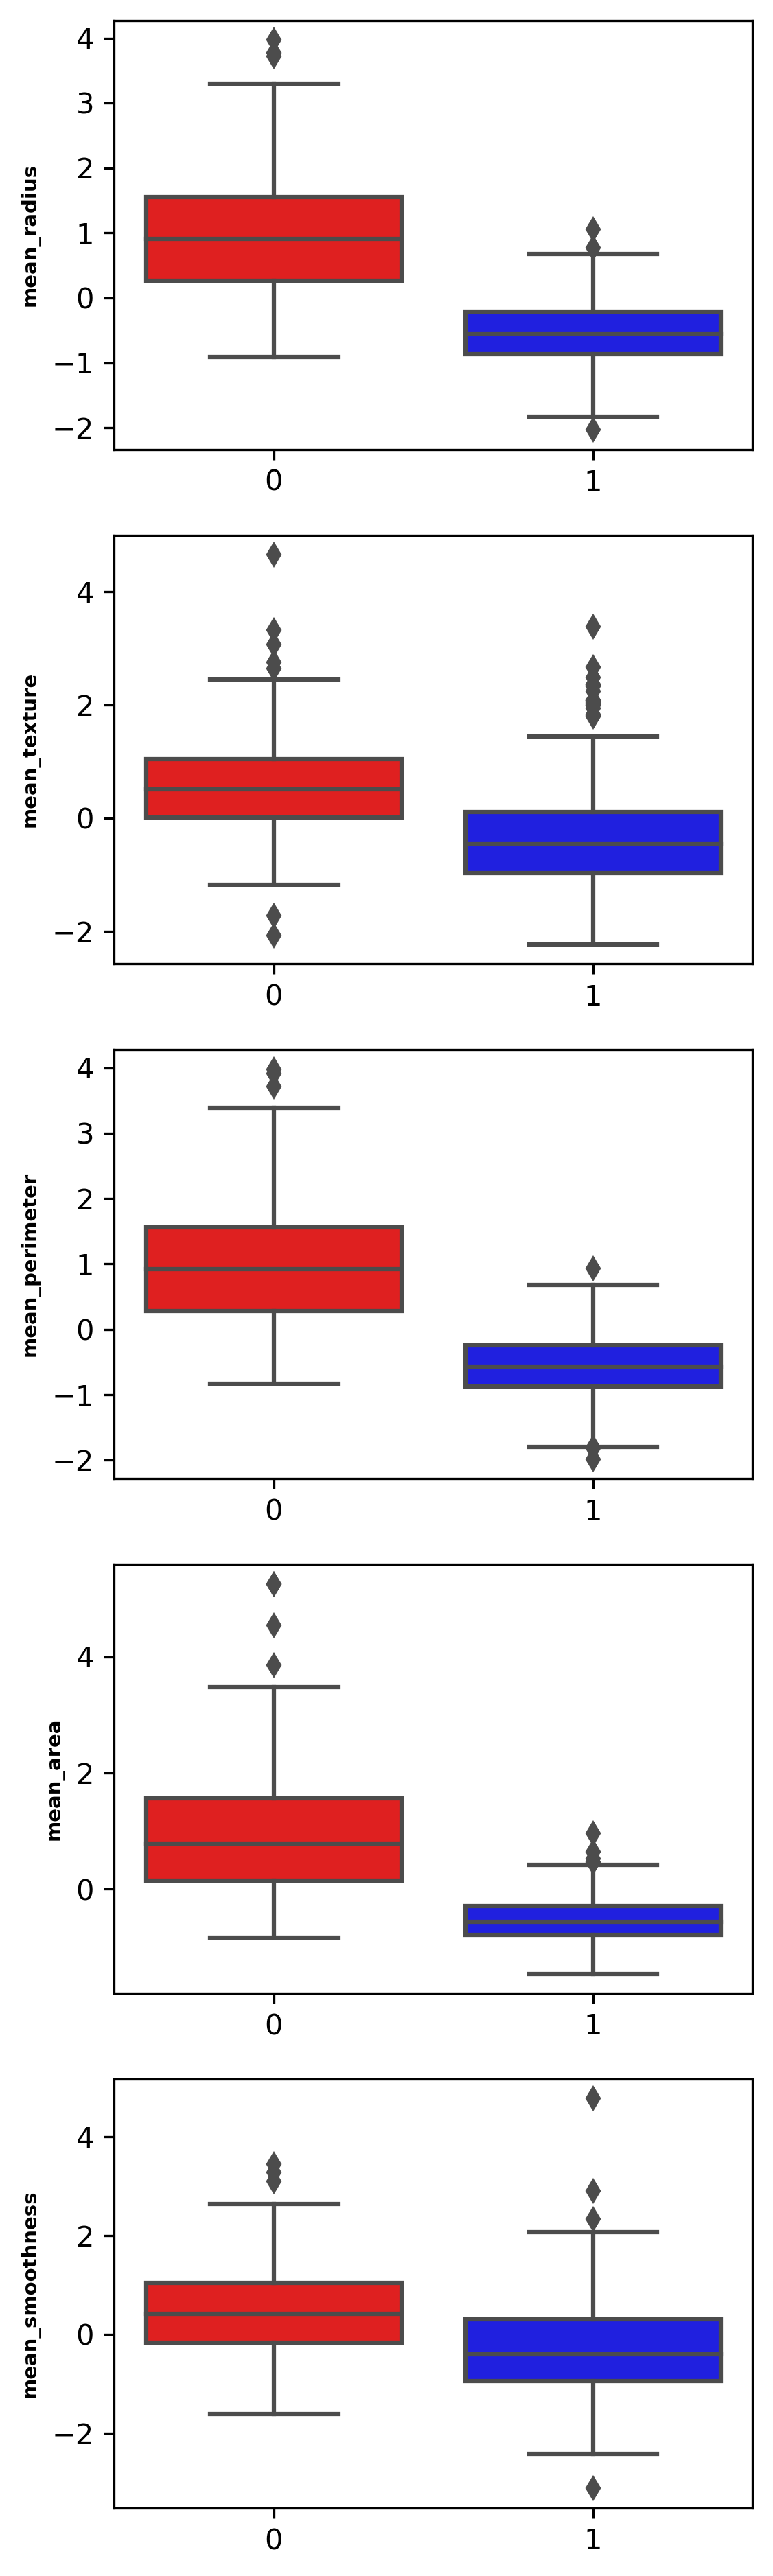

In [7]:
features = list(x_scaled.drop(columns = "diagnosis").columns)

f, axes = plt.subplots(5,1, dpi = 300, figsize = (4,16))

for i, feature in enumerate(features):
    sns.boxplot(data = x_scaled, x = "diagnosis", y = feature, palette = ["red", "blue"], ax = axes[i])
    axes[i].set_ylabel(feature, fontsize = 7, fontweight = "bold")
    axes[i].set_xlabel("")
    

plt.show()

### Heatmap: correlations

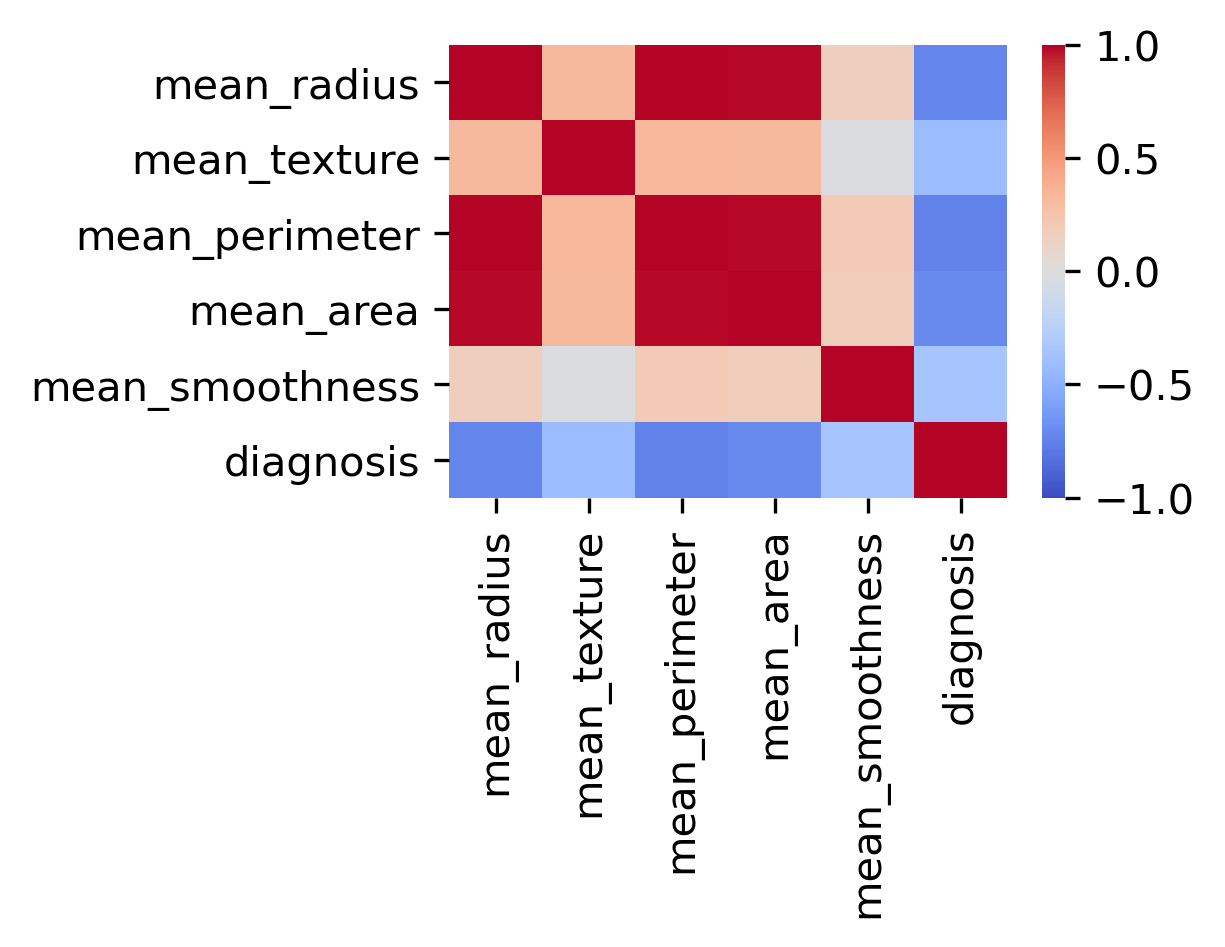

In [8]:
corr = x_scaled.corr()

plt.figure(figsize = (3,2), dpi = 300)

sns.heatmap(corr, vmax = 1, vmin = -1, cmap = "coolwarm")
plt.show()

### PCA decomposition


In [9]:
from sklearn.decomposition import PCA

x = x_scaled.drop(columns = ["diagnosis"])

pca = PCA(n_components = 2).fit(x)

pca_transformed = pca.transform(x)

pca_df = pd.DataFrame(data = {"PC1": pca_transformed[:,0], "PC2": pca_transformed[:,1]})

pca_df["diagnosis"] = y

In [10]:
cum_variance = pca.explained_variance_ratio_

print(round(sum(cum_variance), 2))

0.84


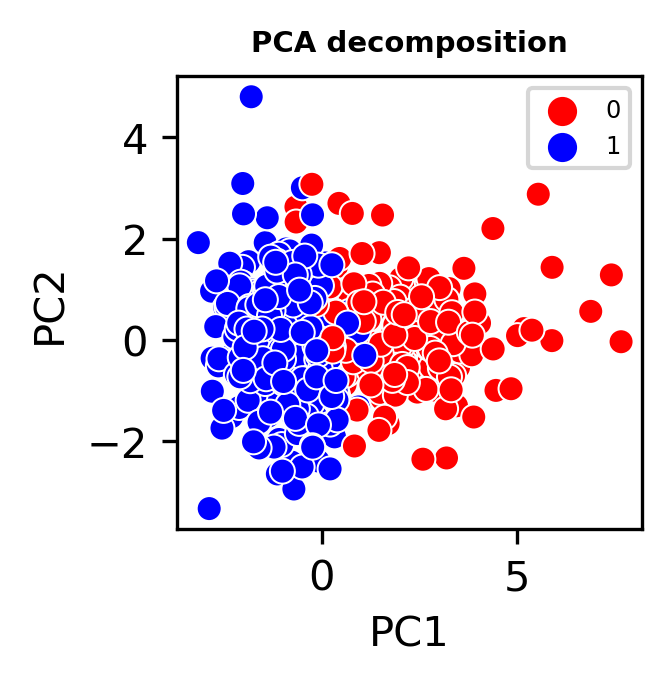

In [11]:
plt.figure(figsize = (2,2), dpi = 300)

sns.scatterplot(data = pca_df, x = 'PC1', y = "PC2", hue = "diagnosis", palette = ["red", "blue"])
plt.legend(fontsize = "xx-small")
plt.title("PCA decomposition", fontsize = 7, fontweight = "bold")
plt.show()

## Machine Learning: training classifiers to predict breast cancer

#### Define CV strategies

In [12]:
#define inner cv strategy

inner_cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle= True)


#define outer cv strategy

outer_cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 5, random_state = 123)

#### Define models

In [ ]:
#logistic regression

lr = LogisticRegression()
lr_grid = {"C": np.logspace(-2,2,5)}
lr_model = GridSearchCV(lr, lr_grid, scoring = "roc_auc", cv = inner_cv)


#linear svc

svc = SVC(probability = True, kernel = "linear")
svc_grid = {"C": np.logspace(-2,2,5)}
svc_model = GridSearchCV(svc, svc_grid, scoring = "roc_auc", cv = inner_cv)



#random forest

rf = RandomForestClassifier(max_depth = None, min_samples_leaf = 1)
rf_grid = {"n_estimators": [300,500], "max_features": ["sqrt", 2]}
rf_model = GridSearchCV(rf, rf_grid, scoring = "roc_auc", cv = inner_cv)


#gradient boosting

gb = GradientBoostingClassifier()
gb_grid = {"max_depth":[3], "n_estimators":[100,200,300], "learning_rate":[0.001, 0.1, 0.2]}
gb_model = GridSearchCV(gb, gb_grid, scoring = "roc_auc", cv = inner_cv)


#light gbm

lgb = LGBMClassifier(boosting_type = "goss", max_depth = -1)
lgb_grid = {"min_split_gain":[0,1,2], "reg_lambda": [0,1,2], "n_estimators":[100,300], "learning_rate":[0.01, 0.1, 0.2]}
lgbm_model = GridSearchCV(lgb, lgb_grid, scoring = "roc_auc", cv = inner_cv)


#insert model instances in a list of tuples

models_list = [("LR",lr_model), ("SVC",svc_model), ("RF",rf_model), ("GB",gb_model), ("LGBM",lgbm_model)] 


#split data

x = x_scaled.drop(columns = ["diagnosis"])
y = x_scaled["diagnosis"]


#initialise objects

roc_auc = []
results = dict()


#run nested cv for each model in list

for label, model in models_list:
    for train, test in outer_cv.split(x,y):
        x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
        if model == lgbm_model:
            model.fit(x_train, y_train, early_stopping_rounds = 10, eval_set = [(x_train, y_train)], eval_metric = "auc")
        else:
            model.fit(x_train, y_train)
        probs = model.predict_proba(x_test)[:,1]
        auc_score = roc_auc_score(y_test, probs)
        roc_auc.append(auc_score)
    
    results[label] = roc_auc
    roc_auc = []
    
    
    
#store results as df
    
df_results = pd.DataFrame(data = results)


### Comparison of model performance across classifiers

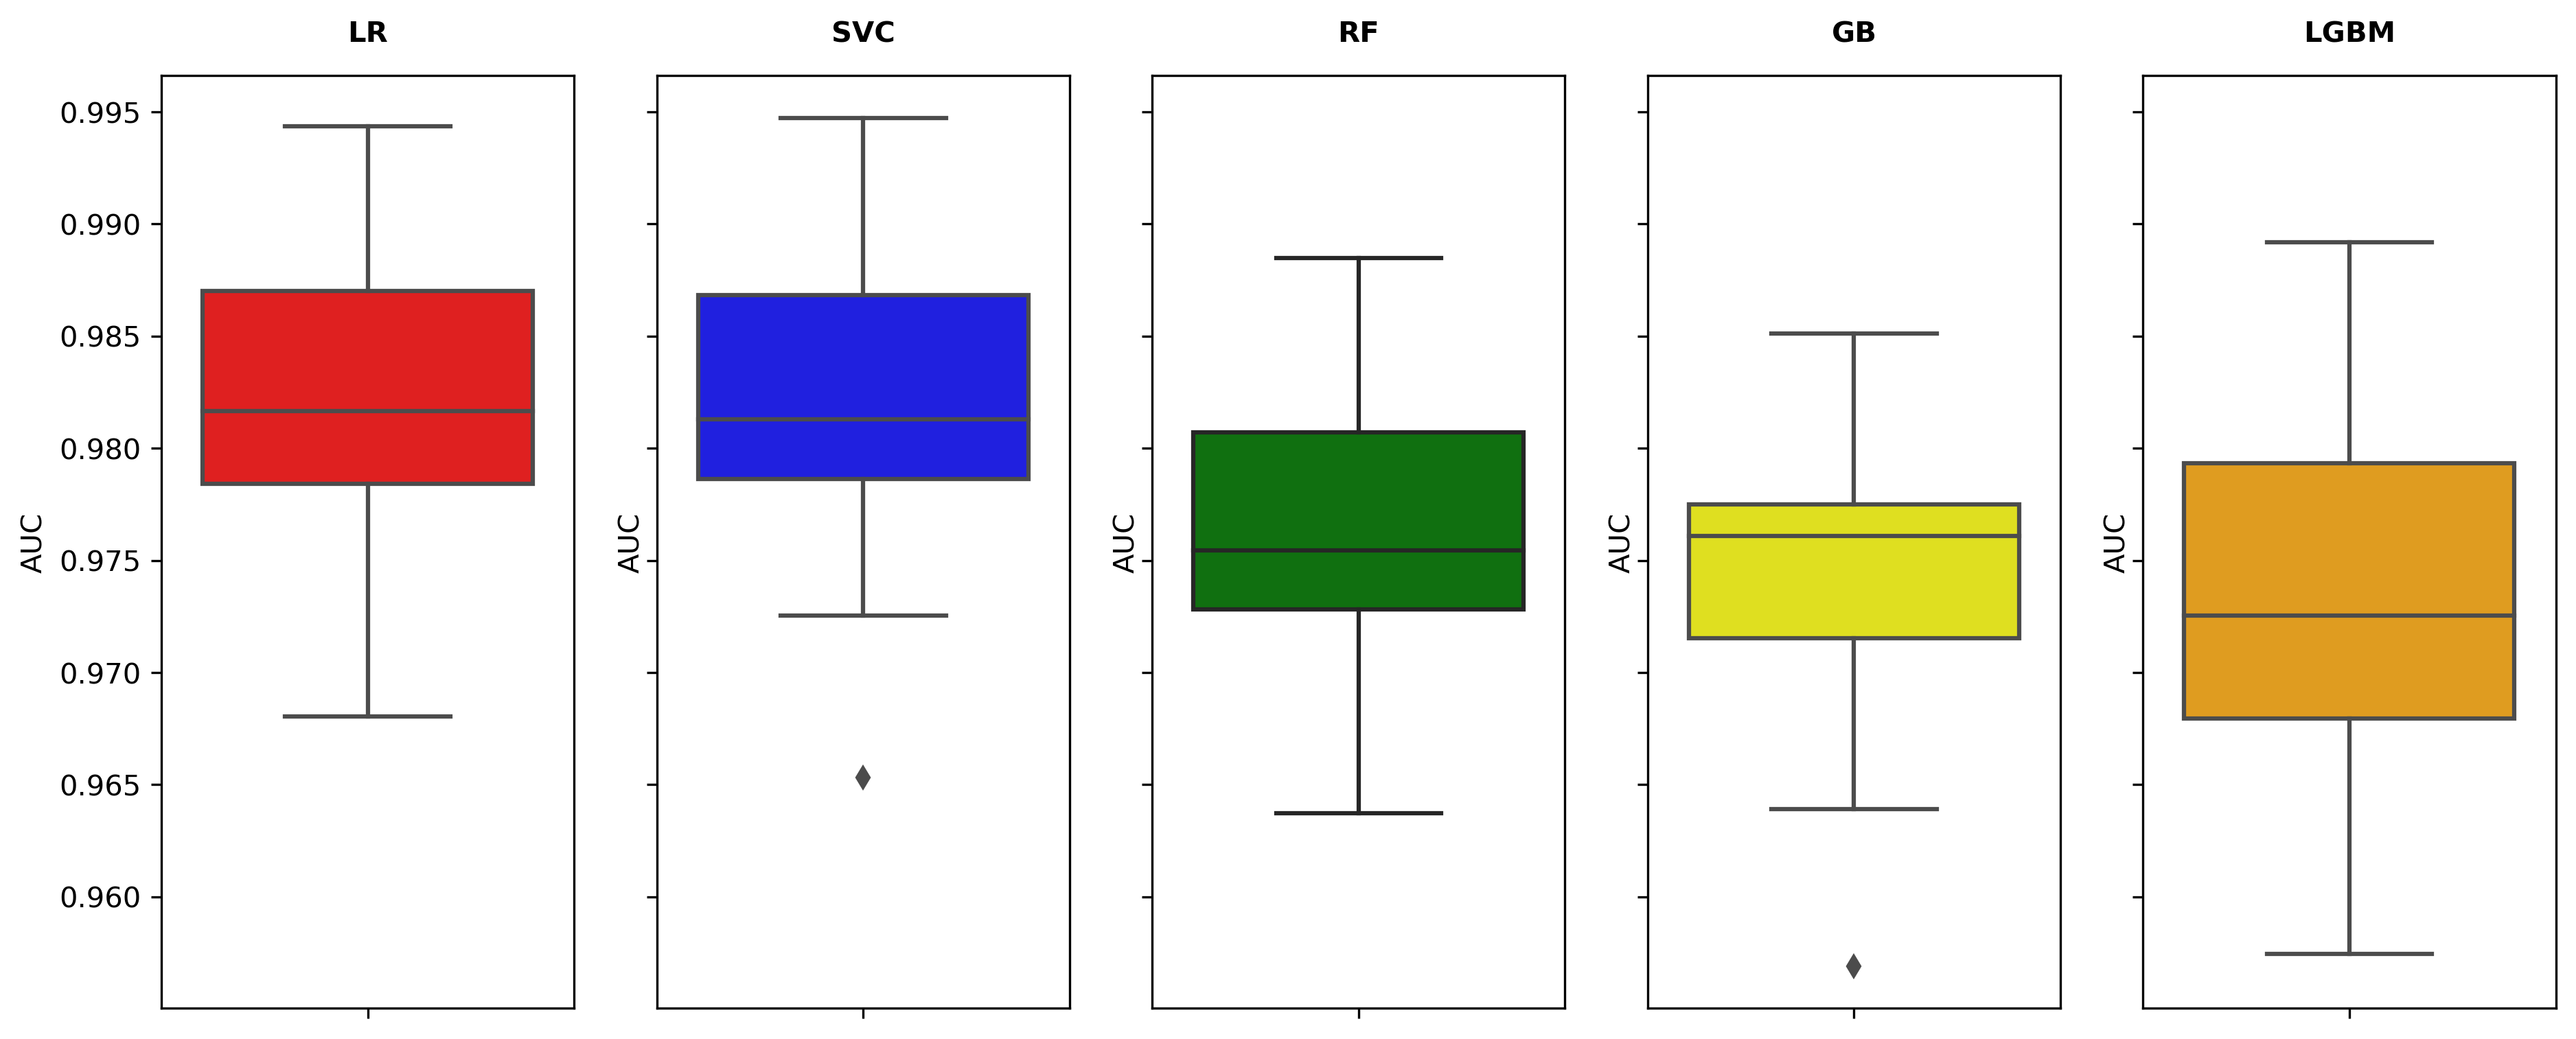

In [32]:
labels = list(df_results.columns)

colors = ["red", "blue", "green", "yellow", "orange"]

f, axes = plt.subplots(1,5, dpi = 300, figsize = (15,6), sharey = True)

for i, label in enumerate(labels):
    sns.boxplot(data = df_results, y = label, ax = axes[i], color = colors[i])
    axes[i].set_ylabel('AUC')
    axes[i].set_title(label, fontweight = "bold", fontsize = 10, pad = 12)

plt.show()

- SVC and LR seem to be the best models. This makes sense since the classes seem to be linearly separable as per the PCA scatterplot.

## Model tuning: LR and SVC

In [ ]:
#enhance grid search in logistic regression and the support vector classifier

lr_grid = {"C": np.logspace(-3,3,7)}
lr_model = GridSearchCV(lr, lr_grid, scoring = "roc_auc", cv = inner_cv, refit = False)

svc_grid = {"C": np.logspace(-3,3,7)}
svc_model = GridSearchCV(svc, svc_grid, scoring = "roc_auc", cv = inner_cv, refit = False)


best_models = [("LR", lr_model), ("SVC", svc_model)]
model_tuning =  dict()
for label, model in best_models:
    model.fit(x,y)
    model_tuning[label] = model.cv_results_
    


In [52]:
#find the best set of parameters for the best models as per CV

for label, model in model_tuning.items():
    best_index = np.argmax(model["mean_test_score"])
    best_params = model["param_C"][best_index]
    print("The best parameter for the", label, "model is ", best_params)


The best parameter for the LR model is  1000.0
The best parameter for the SVC model is  1000.0


#### Compare best two models: LR C = 1000, SVC linear kernel C = 1000

In [54]:
lr = LogisticRegression(C = 1000)
svc = SVC(probability = True, kernel = "linear", C = 1000)

best_models = [("LR", lr), ("SVC", svc)]

best_two = dict()
results_list = []

outer_cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 30, random_state = 42)

for label, model in best_models:
    for train, test in outer_cv.split(x,y):
        x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
        model.fit(x_train, y_train)
        probs = model.predict_proba(x_test)[:,1]
        auc_score = roc_auc_score(y_test, probs)
        results_list.append(auc_score)
    best_two[label] = results_list
    results_list = []
    


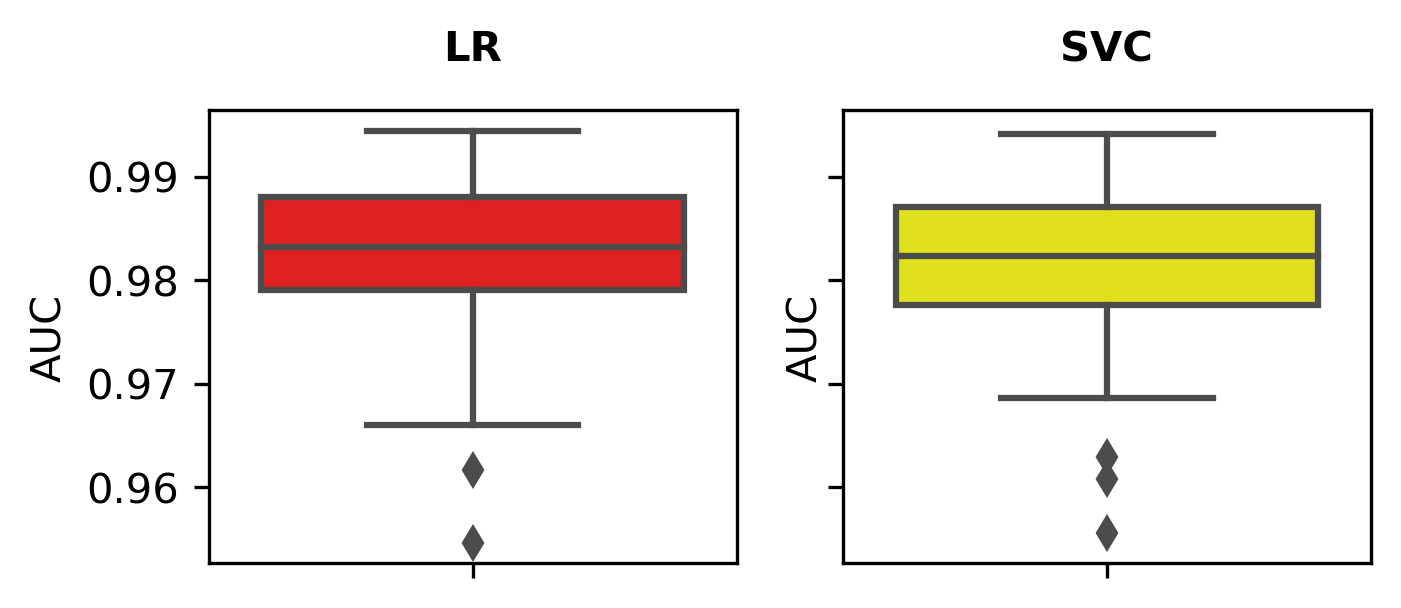

In [56]:
results_df = pd.DataFrame(data = best_two)

labels = ["LR", "SVC"]
colors = ["red", "yellow"]

f, axes = plt.subplots(1,2, dpi = 300, figsize = (5,2), sharey = True)

for i, label in enumerate(labels):
    sns.boxplot(data = results_df, y = label, ax = axes[i], color = colors[i])
    axes[i].set_ylabel('AUC')
    axes[i].set_title(label, fontweight = "bold", fontsize = 10, pad = 12)
    
plt.show()

## Conclusions

Based on this analysis, and as expected from the PCA scatterplots, the two classes can be linearly separated with either a logistic regression model or a support vector classifier with a linear kernel. The best value for the paremeter C was 1000, which is sort of expected due to the (almost) overlap between the two classes.